In [13]:
#Autorzy kodu: Anna Chojnacka, Michał Puchalski, Paweł Sadłowski

In [52]:
path = r"E:/ZMS/ZMS"

import csv
import scipy as sc
import matplotlib.pyplot as plt
from scipy.stats.stats import kstest
import numpy as np
from pandas import DataFrame, concat

%matplotlib inline

In [79]:
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
fullwidth = (5.3, 3.5)

<Container object of 6 artists>

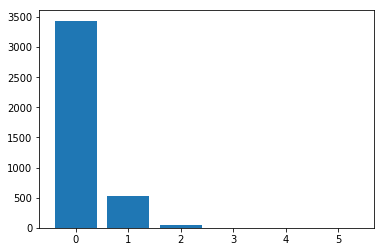

In [2]:
liczba_szkod = {0 : 3437, 
                1 : 522, 
                2 : 40, 
                3 : 2, 
                4 : 0, 
                5 : 0}

plt.bar(list(liczba_szkod.keys()), 
        list(liczba_szkod.values()))

In [3]:
# średnia liczbę szkód:
SREDNIA_LICZBA_SZKOD = (sum([x * y for x, y in liczba_szkod.items()]) / 
                        sum(liczba_szkod.values()))

# czy liczba szkód ma faktycznie rozklad Poissona?
poisson_test = [sc.stats.poisson.pmf(i, SREDNIA_LICZBA_SZKOD) * 
                sum(liczba_szkod.values()) for i in range(len(liczba_szkod))]

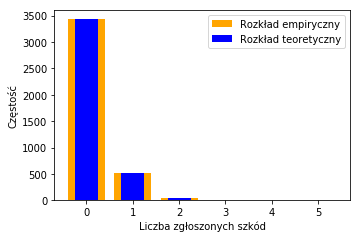

In [78]:
fig = plt.figure(figsize = fullwidth)
plt.bar(list(liczba_szkod.keys()), poisson_test, color = "orange")
plt.bar(list(liczba_szkod.keys()), list(liczba_szkod.values()), color = 'blue', width = 0.5)
plt.ylabel('Częstość')
plt.xlabel('Liczba zgłoszonych szkód')
plt.legend(['Rozkład empiryczny', 'Rozkład teoretyczny'])
fig.savefig(path+r'/raport1/wykresy/rozklad_l_szkod.pdf')

In [6]:
# test chi-kwadrat z biblioteki scipy pomoże odpowiedziec na pytanie:
test1 = sc.stats.chisquare(list(liczba_szkod.values()), f_exp = poisson_test)
if test1[1] > 0.05:
    print ("brak podstaw do odrzucenia hipotezy zerowej")
else:
    print("należy odrzucic hipoteze zerowa")

brak podstaw do odrzucenia hipotezy zerowej


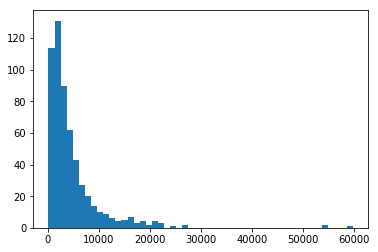

Średnia wielkość szkód: 4742.0


In [7]:
# ### Wielkość szkód
szkody = []
with open(path+'\\szkody.txt','r') as csvfile:
    reader = csv.reader (csvfile, delimiter=";")
    for row in reader:
        szkody.append(int(row[1]))

plt.hist(szkody, bins=50)
plt.show()

print ("Średnia wielkość szkód:", round(sc.mean(szkody))) 

In [8]:
# wielkość szkód ma rozkład log-normalny:
szkody_ln = sc.log(szkody)

# ... czy faktycznie? test K-S
test2 = kstest(szkody_ln, sc.stats.norm.cdf, 
               args = (sc.mean(szkody_ln), sc.std(szkody_ln)))
if test2[1] > 0.05:
    print ("p-value wyniosło:", round(test2[1], 4), 
           "- brak więc podstaw do odrzucenia hipotezy " +
           "o log-normalności rozkładu zmiennej")
else:
    print ("należy odrzucic hipotezę zerowa")

p-value wyniosło: 0.9979 - brak więc podstaw do odrzucenia hipotezy o log-normalności rozkładu zmiennej


In [9]:
# parametry wielkości szkód potrzebne do symulacji:
SR_SZKODA_LN = sc.mean(szkody_ln)
STD_SZKODA_LN = sc.std(szkody_ln)

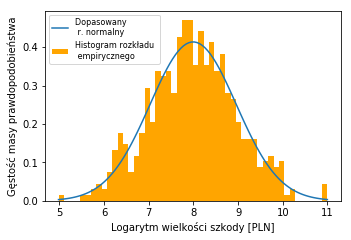

In [113]:
fig = plt.figure(figsize = fullwidth)
plt.hist(szkody_ln, bins=50, density = True, color = 'orange')
x_norm = np.linspace(min(szkody_ln), max(szkody_ln), 100)
y_norm = sc.stats.norm.pdf(x_norm, SR_SZKODA_LN, STD_SZKODA_LN)
plt.plot(x_norm, y_norm)
plt.legend(['Dopasowany \n r. normalny', 'Histogram rozkładu \n empirycznego'], fontsize = 8, loc = 'upper left')
plt.ylabel('Gęstość masy prawdopodobieństwa')
plt.xlabel('Logarytm wielkości szkody [PLN]')
fig.savefig(path+r'/raport1/wykresy/rozklad_wys_szkody.pdf')

In [10]:
# ## 2. Model symulacji
def model (liczba_klientow, srednia_liczba_szkod, 
           sr_szkoda_ln, std_szkoda_ln, horyzont, 
           nadwyzka, skladka, seed):
    
    # Common Random Numbers aby moc porownac rozne scenariusze:
    sc.random.seed(seed) 

    # definiujemy daty umów klientow w symulacji:
    daty_umow = [sc.random.randint(0, 364) for i in range(liczba_klientow)]
    kalendarz_wplat = [0]*365
    for dataUmowy in daty_umow:
        kalendarz_wplat[dataUmowy] += 1

    # liczymy liczbe szkód przypadających na jednego klienta:
    liczba_szkod_klienta = sc.random.poisson(srednia_liczba_szkod, 
                                             liczba_klientow)
    
    # i ustalamy daty wyplaty dla wszystkich polis:
    kalendarz_wyplat = [0]*(365*horyzont) 
    for k in range(liczba_klientow):
        for s in range(liczba_szkod_klienta[k]):
            data_wyplaty = daty_umow[k] + sc.random.randint(0, 364)
            kalendarz_wyplat[data_wyplaty] += 1
    
    
    # analiza wyników firmy dla danego horyzontu czasowego i danych szkód:
    for dzien in range(365*horyzont):
        if dzien <= 364:
            nadwyzka += kalendarz_wplat[dzien] * skladka
        liczba_wyplat = kalendarz_wyplat[dzien]
        odszkodowania = 0 
        if liczba_wyplat > 0:
            odszkodowania = sum(sc.exp(sc.random.normal(sr_szkoda_ln, 
                                                        std_szkoda_ln, 
                                                        liczba_wyplat)))
        if nadwyzka < odszkodowania:
            return nadwyzka - odszkodowania
        else:
            pass
        nadwyzka -= odszkodowania
    return nadwyzka


# ### ... i funkcja, która go wywoła *n* razy

In [11]:
def wywolanie(nadwyzka, skladka, liczba_powtorzen, 
              liczba_klientow, srednia_liczba_szkod , 
              sr_szkoda_ln, std_szkoda_ln, horyzont):
    wynik = []
    bankructwo = 0
    wynik_dodatni = []
    for seed in range(liczba_powtorzen):
        wynik.append(model(liczba_klientow, srednia_liczba_szkod , 
                           sr_szkoda_ln, std_szkoda_ln, horyzont, 
                           nadwyzka, skladka, seed))
        if wynik[seed] < 0:
            bankructwo += 1
        if wynik[seed] > 0:
            wynik_dodatni.append(wynik[seed])
    sredni_wynik = sc.mean(wynik_dodatni)
    odch_stand_wynik = sc.std(wynik_dodatni)
    prawd_bankr = bankructwo / liczba_powtorzen
    return [bankructwo, prawd_bankr, sredni_wynik, odch_stand_wynik]

Nadwyzka:  5000 Skladka:  500 Liczba ruin:  713 Sredni wynik:  13462.0 Prawd_bankr:  0.713
Nadwyzka:  5000 Skladka:  600 Liczba ruin:  565 Sredni wynik:  17282.0 Prawd_bankr:  0.565
Nadwyzka:  5000 Skladka:  700 Liczba ruin:  422 Sredni wynik:  21805.0 Prawd_bankr:  0.422
Nadwyzka:  5000 Skladka:  800 Liczba ruin:  292 Sredni wynik:  27040.0 Prawd_bankr:  0.292
Nadwyzka:  5000 Skladka:  900 Liczba ruin:  187 Sredni wynik:  33076.0 Prawd_bankr:  0.187
Nadwyzka:  5000 Skladka:  1000 Liczba ruin:  125 Sredni wynik:  40470.0 Prawd_bankr:  0.125
Nadwyzka:  5000 Skladka:  1100 Liczba ruin:  70 Sredni wynik:  47927.0 Prawd_bankr:  0.07
Nadwyzka:  5000 Skladka:  1200 Liczba ruin:  48 Sredni wynik:  56866.0 Prawd_bankr:  0.048
Nadwyzka:  5000 Skladka:  1300 Liczba ruin:  29 Sredni wynik:  65759.0 Prawd_bankr:  0.029
Nadwyzka:  5000 Skladka:  1400 Liczba ruin:  23 Sredni wynik:  75426.0 Prawd_bankr:  0.023
Nadwyzka:  5000 Skladka:  1500 Liczba ruin:  16 Sredni wynik:  84910.0 Prawd_bankr:  0.016

KeyboardInterrupt: 

In [ ]:
# ## 3. Symulacja

# zmienne i parametry w modelu:
sr_wynik = [] # średni wynik finansowy firmy
odch_stand_wynik = [] # Odch. stand. sredniego wyniku
wysokosc_skladki = []
wysokosc_nadwyzki = []
prawd_bankr = []
liczba_ruin = [] 

LICZBA_POWTORZEN = 1000
LICZBA_KLIENTOW = 100
HORYZONT = 2 # dlugość obowiązywania umowy - zakładamy 2 lata


for nadwyzka in range(5000, 21000, 1000):
    for skladka in range(500, 2100, 100):
        wartosc_f_xy = wywolanie(nadwyzka, skladka, 
                                 LICZBA_POWTORZEN, LICZBA_KLIENTOW, 
                                 SREDNIA_LICZBA_SZKOD , SR_SZKODA_LN, 
                                 STD_SZKODA_LN, HORYZONT)
        wysokosc_skladki.append(skladka)
        wysokosc_nadwyzki.append(nadwyzka)
        liczba_ruin.append(wartosc_f_xy[0])
        prawd_bankr.append(wartosc_f_xy[1])
        sr_wynik.append(wartosc_f_xy[2])
        odch_stand_wynik.append(wartosc_f_xy[3])
        print("Nadwyzka: ", nadwyzka, "Skladka: ", skladka, 
              "Liczba ruin: ", wartosc_f_xy[0], "Sredni wynik: ",
              round(wartosc_f_xy[2]), "Prawd_bankr: ", wartosc_f_xy[1])

dane = DataFrame.from_dict({'nadwyzka': wysokosc_nadwyzki,
                            'skladka': wysokosc_skladki,
                            'liczba_ruin': liczba_ruin,
                            'prawd_bankr': prawd_bankr,
                            'sr_wynik': sr_wynik,
                            'odch_stand_wynik': odch_stand_wynik},
        orient = 'columns')

dane.set_index(['nadwyzka', 'skladka'], inplace = True)

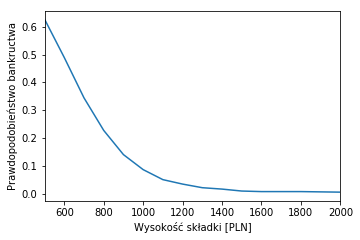

In [82]:
fig, ax = plt.subplots(figsize = fullwidth)
dane.loc[(10000,slice(None)),'prawd_bankr'].reset_index(). \
    plot(x = 'skladka', y = 'prawd_bankr', legend = False, ax = ax)
ax.set_xlabel('Wysokość składki [PLN]')
ax.set_ylabel('Prawdopodobieństwo bankructwa')
fig.savefig(path+r'\raport1\wykresy\p_bankructwa.pdf')

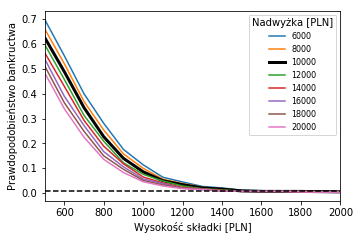

In [97]:
fig, ax = plt.subplots(figsize = fullwidth)
dane.loc[(list(range(6000,10000,2000)), slice(None)),'prawd_bankr'].reset_index().groupby('nadwyzka'). \
    plot(x = 'skladka', y = 'prawd_bankr', ax = ax)
dane.loc[(10000, slice(None)), 'prawd_bankr'].reset_index().plot(x = 'skladka', y = 'prawd_bankr', ax = ax,
                                                                color = 'k', linewidth = 3)
dane.loc[(list(range(12000,22000,2000)), slice(None)),'prawd_bankr'].reset_index().groupby('nadwyzka'). \
    plot(x = 'skladka', y = 'prawd_bankr', ax = ax)
ax.set_xlabel('Wysokość składki [PLN]')
ax.set_ylabel('Prawdopodobieństwo bankructwa')
ax.legend(labels = [str(x) for x in range(6000, 22000, 2000)], title = 'Nadwyżka [PLN]', fontsize = 8)
ax.axhline(y = 0.01, color = 'k' , linestyle = '--')
fig.savefig(path+r'\raport1\wykresy\p_bankructwa_porownanie.pdf')

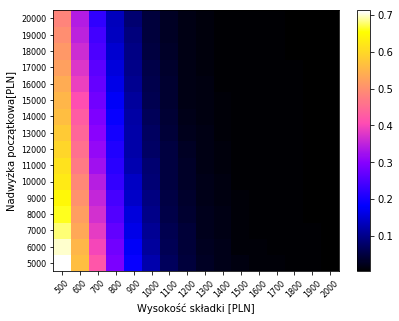

In [98]:
df2 = (dane.pivot_table(index='nadwyzka', columns='skladka', values='prawd_bankr').reset_index())

fig = plt.figure(figsize=(6.4,4.8))
heatmap = plt.pcolor(df2.iloc[:, 1:], cmap='gnuplot2')
plt.yticks(np.arange(0.5, len(df2.iloc[:,0]), 1), df2.iloc[:,0], fontsize = 8)
plt.xticks(np.arange(0.5, len(df2.columns[1:]), 1), df2.columns[1:], fontsize = 8, rotation = 45)
plt.xlabel('Wysokość składki [PLN]')
plt.ylabel('Nadwyżka początkowa[PLN]')
plt.colorbar(heatmap)
plt.show()

fig.savefig(path+r'/raport1/wykresy/p_heatmapa_bankructwo.pdf')

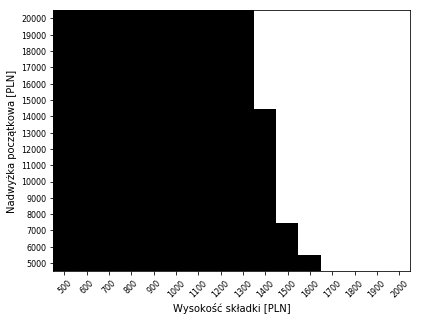

In [94]:
fig = plt.figure(figsize = (6.4,4.8))
heatmap = plt.pcolor(df2.iloc[:, 1:] <= 0.01, cmap='gnuplot2')
plt.yticks(np.arange(0.5, len(df2.iloc[:,0]), 1), df2.iloc[:,0], fontsize = 8)
plt.xticks(np.arange(0.5, len(df2.columns[1:]), 1), df2.columns[1:], fontsize = 8, rotation = 45)
plt.xlabel('Wysokość składki [PLN]')
plt.ylabel('Nadwyżka początkowa [PLN]')
plt.show()

fig.savefig(path+r'/raport1/wykresy/p_heatmapa_bankructwo_mniej_niz_0,01.pdf')

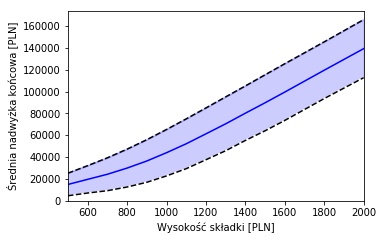

In [110]:
# ## RAPORT 
# 
# ### Zbadaj płynność firmy w zależności od parametrów
# 
# **Pytania**
# 1. Jaką ustalić składkę OC, aby ruina kierowców nie była udziałem PiTU S.A.?
# 2. Czy nadwyżka końcowa będzie równa początkowej?
# 3. Jakie jest zagrożenie ruiną?
# 4. Jaka powinna być nadwyżka i składka, żeby prawdopodobieństwo ruiny było mniejsze niż 0,01?
# 5. Jak liczba symulacji wpływa na wyniki?

# %%
# Wykres sredniej koncowej nadwyzki dodatniej

plotdata = dane.loc[(10000, slice(None)),['sr_wynik', 'odch_stand_wynik']]
plotdata['upper'] = plotdata.sr_wynik + plotdata.odch_stand_wynik
plotdata['lower'] = plotdata.sr_wynik - plotdata.odch_stand_wynik

fig, ax = plt.subplots(figsize = fullwidth)
plotdata.reset_index().plot(x = 'skladka', y = 'upper', legend = False,
                    ax = ax, kind = 'area', color = 'blue', alpha = 0.2)
plotdata.reset_index().plot(x = 'skladka', y = 'lower', legend = False,
                    ax = ax, kind = 'area', color = 'white')
plotdata.reset_index().plot(x = 'skladka', y = ['sr_wynik', 'upper', 'lower'],
                    legend = False, ax = ax, style = ['b', '--k', '--k'])
ax.set_xlabel('Wysokość składki [PLN]')
ax.set_ylabel('Średnia nadwyżka końcowa [PLN]')
fig.savefig(path+r'/raport1/wykresy/nadwyzka.pdf')

In [ ]:
# ## 3. Symulacja

# zmienne i parametry w modelu:
sr_wynik = [] # średni wynik finansowy firmy
odch_stand_wynik = [] # Odch. stand. sredniego wyniku
wysokosc_skladki = []
wysokosc_nadwyzki = []
prawd_bankr = []
liczba_ruin = [] 

LICZBA_POWTORZEN = 1000
LICZBA_KLIENTOW = 100
HORYZONT = 2 # dlugość obowiązywania umowy - zakładamy 2 lata


for nadwyzka in range(5000, 21000, 1000):
    for skladka in range(500, 2100, 100):
        wartosc_f_xy = wywolanie(nadwyzka, skladka, 
                                 LICZBA_POWTORZEN, LICZBA_KLIENTOW, 
                                 SREDNIA_LICZBA_SZKOD , SR_SZKODA_LN, 
                                 STD_SZKODA_LN, HORYZONT)
        wysokosc_skladki.append(skladka)
        wysokosc_nadwyzki.append(nadwyzka)
        liczba_ruin.append(wartosc_f_xy[0])
        prawd_bankr.append(wartosc_f_xy[1])
        sr_wynik.append(wartosc_f_xy[2])
        odch_stand_wynik.append(wartosc_f_xy[3])
        print("Nadwyzka: ", nadwyzka, "Skladka: ", skladka, 
              "Liczba ruin: ", wartosc_f_xy[0], "Sredni wynik: ",
              round(wartosc_f_xy[2]), "Prawd_bankr: ", wartosc_f_xy[1])

lambda_up = DataFrame.from_dict({'nadwyzka': wysokosc_nadwyzki,
                            'skladka': wysokosc_skladki,
                            'liczba_ruin': liczba_ruin,
                            'prawd_bankr': prawd_bankr,
                            'sr_wynik': sr_wynik,
                            'odch_stand_wynik': odch_stand_wynik},
        orient = 'columns')

lambda_up.set_index(['nadwyzka', 'skladka'], inplace = True)

In [ ]:
# ## 3. Symulacja

# zmienne i parametry w modelu:
sr_wynik = [] # średni wynik finansowy firmy
odch_stand_wynik = [] # Odch. stand. sredniego wyniku
wysokosc_skladki = []
wysokosc_nadwyzki = []
prawd_bankr = []
liczba_ruin = [] 

LICZBA_POWTORZEN = 1000
LICZBA_KLIENTOW = 100
HORYZONT = 2 # dlugość obowiązywania umowy - zakładamy 2 lata


for nadwyzka in range(5000, 21000, 1000):
    for skladka in range(500, 2100, 100):
        wartosc_f_xy = wywolanie(nadwyzka, skladka, 
                                 LICZBA_POWTORZEN, LICZBA_KLIENTOW, 
                                 SREDNIA_LICZBA_SZKOD , SR_SZKODA_LN, 
                                 STD_SZKODA_LN, HORYZONT)
        wysokosc_skladki.append(skladka)
        wysokosc_nadwyzki.append(nadwyzka)
        liczba_ruin.append(wartosc_f_xy[0])
        prawd_bankr.append(wartosc_f_xy[1])
        sr_wynik.append(wartosc_f_xy[2])
        odch_stand_wynik.append(wartosc_f_xy[3])
        print("Nadwyzka: ", nadwyzka, "Skladka: ", skladka, 
              "Liczba ruin: ", wartosc_f_xy[0], "Sredni wynik: ",
              round(wartosc_f_xy[2]), "Prawd_bankr: ", wartosc_f_xy[1])

lambda_down = DataFrame.from_dict({'nadwyzka': wysokosc_nadwyzki,
                            'skladka': wysokosc_skladki,
                            'liczba_ruin': liczba_ruin,
                            'prawd_bankr': prawd_bankr,
                            'sr_wynik': sr_wynik,
                            'odch_stand_wynik': odch_stand_wynik},
        orient = 'columns')

lambda_down.set_index(['nadwyzka', 'skladka'], inplace = True)

In [18]:
df = concat([dane, lambda_up, lambda_down], keys = ['bazowy', 'plus', 'minus'], names = ['scenariusz'])

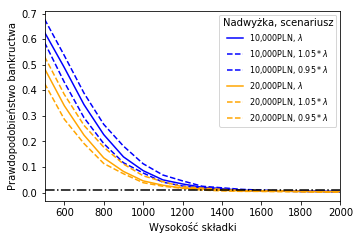

In [109]:
fig, ax = plt.subplots(figsize = fullwidth)
for k,v in {10000:'blue', 20000:'orange'}.items():
    df.loc[('bazowy', k, slice(None)),:].reset_index(). \
        plot(x = 'skladka', y = 'prawd_bankr', color = v, ax = ax, legend = False)
    df.loc[(['plus', 'minus'], k, slice(None)),:].reset_index().groupby('scenariusz'). \
        plot(x = 'skladka', y = 'prawd_bankr', color = v, style = '--', ax = ax, legend = False)
ax.set_xlabel('Wysokość składki')
ax.set_ylabel('Prawdopodobieństwo bankructwa')
ax.axhline(y = 0.01, color = 'k', linestyle = '-.')
ax.legend(labels = [x+'PLN, '+y for x in ['10,000', '20,000'] \
                    for y in [r'$\lambda$', r'$1.05 * \lambda$', r'$0.95 * \lambda$']],
         title = 'Nadwyżka, scenariusz', fontsize = 8)
fig.savefig(path+r'/raport1/wykresy/p_bankructwa_all.pdf')

In [35]:
# Powtorka symulacji, lambda +5%
sr_wynik = [] # średni wynik finansowy firmy
odch_stand_wynik = [] # Odch. stand. sredniego wyniku
wysokosc_skladki = []
wysokosc_nadwyzki = []
prawd_bankr = []
liczba_ruin = [] 

LICZBA_POWTORZEN = 1500
LICZBA_KLIENTOW = 100
HORYZONT = 2 # dlugość obowiązywania umowy - zakładamy 2 lata


for nadwyzka in range(5000, 21000, 1000):
    for skladka in range(500, 2100, 100):
        wartosc_f_xy = wywolanie(nadwyzka, skladka, 
                                 LICZBA_POWTORZEN, LICZBA_KLIENTOW, 
                                 SREDNIA_LICZBA_SZKOD , SR_SZKODA_LN, 
                                 STD_SZKODA_LN, HORYZONT)
        wysokosc_skladki.append(skladka)
        wysokosc_nadwyzki.append(nadwyzka)
        liczba_ruin.append(wartosc_f_xy[0])
        prawd_bankr.append(wartosc_f_xy[1])
        sr_wynik.append(wartosc_f_xy[2])
        odch_stand_wynik.append(wartosc_f_xy[3])
        print("Nadwyzka: ", nadwyzka, "Skladka: ", skladka, 
              "Liczba ruin: ", wartosc_f_xy[0], "Sredni wynik: ",
              round(wartosc_f_xy[2]), "Prawd_bankr: ", wartosc_f_xy[1])

piecset = DataFrame.from_dict({'nadwyzka': wysokosc_nadwyzki,
                            'skladka': wysokosc_skladki,
                            'liczba_ruin': liczba_ruin,
                            'prawd_bankr': prawd_bankr,
                            'sr_wynik': sr_wynik,
                            'odch_stand_wynik': odch_stand_wynik},
        orient = 'columns')

piecset.set_index(['nadwyzka', 'skladka'], inplace = True)

Nadwyzka:  5000 Skladka:  500 Liczba ruin:  1060 Sredni wynik:  13618.0 Prawd_bankr:  0.7066666666666667
Nadwyzka:  5000 Skladka:  600 Liczba ruin:  846 Sredni wynik:  17566.0 Prawd_bankr:  0.564
Nadwyzka:  5000 Skladka:  700 Liczba ruin:  643 Sredni wynik:  22276.0 Prawd_bankr:  0.42866666666666664
Nadwyzka:  5000 Skladka:  800 Liczba ruin:  447 Sredni wynik:  27370.0 Prawd_bankr:  0.298
Nadwyzka:  5000 Skladka:  900 Liczba ruin:  288 Sredni wynik:  33350.0 Prawd_bankr:  0.192
Nadwyzka:  5000 Skladka:  1000 Liczba ruin:  194 Sredni wynik:  40677.0 Prawd_bankr:  0.12933333333333333
Nadwyzka:  5000 Skladka:  1100 Liczba ruin:  120 Sredni wynik:  48402.0 Prawd_bankr:  0.08
Nadwyzka:  5000 Skladka:  1200 Liczba ruin:  84 Sredni wynik:  57147.0 Prawd_bankr:  0.056
Nadwyzka:  5000 Skladka:  1300 Liczba ruin:  53 Sredni wynik:  65942.0 Prawd_bankr:  0.035333333333333335
Nadwyzka:  5000 Skladka:  1400 Liczba ruin:  36 Sredni wynik:  75256.0 Prawd_bankr:  0.024
Nadwyzka:  5000 Skladka:  1500 L

Nadwyzka:  10000 Skladka:  700 Liczba ruin:  516 Sredni wynik:  24383.0 Prawd_bankr:  0.344
Nadwyzka:  10000 Skladka:  800 Liczba ruin:  350 Sredni wynik:  30211.0 Prawd_bankr:  0.23333333333333334
Nadwyzka:  10000 Skladka:  900 Liczba ruin:  217 Sredni wynik:  36656.0 Prawd_bankr:  0.14466666666666667
Nadwyzka:  10000 Skladka:  1000 Liczba ruin:  142 Sredni wynik:  44419.0 Prawd_bankr:  0.09466666666666666
Nadwyzka:  10000 Skladka:  1100 Liczba ruin:  91 Sredni wynik:  52662.0 Prawd_bankr:  0.06066666666666667
Nadwyzka:  10000 Skladka:  1200 Liczba ruin:  59 Sredni wynik:  61460.0 Prawd_bankr:  0.03933333333333333
Nadwyzka:  10000 Skladka:  1300 Liczba ruin:  35 Sredni wynik:  70395.0 Prawd_bankr:  0.023333333333333334
Nadwyzka:  10000 Skladka:  1400 Liczba ruin:  25 Sredni wynik:  79994.0 Prawd_bankr:  0.016666666666666666
Nadwyzka:  10000 Skladka:  1500 Liczba ruin:  15 Sredni wynik:  89548.0 Prawd_bankr:  0.01
Nadwyzka:  10000 Skladka:  1600 Liczba ruin:  12 Sredni wynik:  99356.0 

Nadwyzka:  15000 Skladka:  800 Liczba ruin:  270 Sredni wynik:  33196.0 Prawd_bankr:  0.18
Nadwyzka:  15000 Skladka:  900 Liczba ruin:  176 Sredni wynik:  40554.0 Prawd_bankr:  0.11733333333333333
Nadwyzka:  15000 Skladka:  1000 Liczba ruin:  103 Sredni wynik:  48222.0 Prawd_bankr:  0.06866666666666667
Nadwyzka:  15000 Skladka:  1100 Liczba ruin:  69 Sredni wynik:  56987.0 Prawd_bankr:  0.046
Nadwyzka:  15000 Skladka:  1200 Liczba ruin:  38 Sredni wynik:  65718.0 Prawd_bankr:  0.025333333333333333
Nadwyzka:  15000 Skladka:  1300 Liczba ruin:  25 Sredni wynik:  75125.0 Prawd_bankr:  0.016666666666666666
Nadwyzka:  15000 Skladka:  1400 Liczba ruin:  15 Sredni wynik:  84594.0 Prawd_bankr:  0.01
Nadwyzka:  15000 Skladka:  1500 Liczba ruin:  12 Sredni wynik:  94443.0 Prawd_bankr:  0.008
Nadwyzka:  15000 Skladka:  1600 Liczba ruin:  8 Sredni wynik:  104178.0 Prawd_bankr:  0.005333333333333333
Nadwyzka:  15000 Skladka:  1700 Liczba ruin:  7 Sredni wynik:  114134.0 Prawd_bankr:  0.004666666666

Nadwyzka:  20000 Skladka:  800 Liczba ruin:  209 Sredni wynik:  36553.0 Prawd_bankr:  0.13933333333333334
Nadwyzka:  20000 Skladka:  900 Liczba ruin:  136 Sredni wynik:  44343.0 Prawd_bankr:  0.09066666666666667
Nadwyzka:  20000 Skladka:  1000 Liczba ruin:  82 Sredni wynik:  52525.0 Prawd_bankr:  0.05466666666666667
Nadwyzka:  20000 Skladka:  1100 Liczba ruin:  52 Sredni wynik:  61337.0 Prawd_bankr:  0.034666666666666665
Nadwyzka:  20000 Skladka:  1200 Liczba ruin:  29 Sredni wynik:  70322.0 Prawd_bankr:  0.019333333333333334
Nadwyzka:  20000 Skladka:  1300 Liczba ruin:  20 Sredni wynik:  79894.0 Prawd_bankr:  0.013333333333333334
Nadwyzka:  20000 Skladka:  1400 Liczba ruin:  13 Sredni wynik:  89505.0 Prawd_bankr:  0.008666666666666666
Nadwyzka:  20000 Skladka:  1500 Liczba ruin:  10 Sredni wynik:  99313.0 Prawd_bankr:  0.006666666666666667
Nadwyzka:  20000 Skladka:  1600 Liczba ruin:  7 Sredni wynik:  109134.0 Prawd_bankr:  0.004666666666666667
Nadwyzka:  20000 Skladka:  1700 Liczba r

In [35]:
# Powtorka symulacji, lambda +5%
sr_wynik = [] # średni wynik finansowy firmy
odch_stand_wynik = [] # Odch. stand. sredniego wyniku
wysokosc_skladki = []
wysokosc_nadwyzki = []
prawd_bankr = []
liczba_ruin = [] 

LICZBA_POWTORZEN = 1500
LICZBA_KLIENTOW = 100
HORYZONT = 2 # dlugość obowiązywania umowy - zakładamy 2 lata


for nadwyzka in range(5000, 21000, 1000):
    for skladka in range(500, 2100, 100):
        wartosc_f_xy = wywolanie(nadwyzka, skladka, 
                                 LICZBA_POWTORZEN, LICZBA_KLIENTOW, 
                                 SREDNIA_LICZBA_SZKOD , SR_SZKODA_LN, 
                                 STD_SZKODA_LN, HORYZONT)
        wysokosc_skladki.append(skladka)
        wysokosc_nadwyzki.append(nadwyzka)
        liczba_ruin.append(wartosc_f_xy[0])
        prawd_bankr.append(wartosc_f_xy[1])
        sr_wynik.append(wartosc_f_xy[2])
        odch_stand_wynik.append(wartosc_f_xy[3])
        print("Nadwyzka: ", nadwyzka, "Skladka: ", skladka, 
              "Liczba ruin: ", wartosc_f_xy[0], "Sredni wynik: ",
              round(wartosc_f_xy[2]), "Prawd_bankr: ", wartosc_f_xy[1])

tys_piecset = DataFrame.from_dict({'nadwyzka': wysokosc_nadwyzki,
                            'skladka': wysokosc_skladki,
                            'liczba_ruin': liczba_ruin,
                            'prawd_bankr': prawd_bankr,
                            'sr_wynik': sr_wynik,
                            'odch_stand_wynik': odch_stand_wynik},
        orient = 'columns')

tys_piecset.set_index(['nadwyzka', 'skladka'], inplace = True)

Nadwyzka:  5000 Skladka:  500 Liczba ruin:  1060 Sredni wynik:  13618.0 Prawd_bankr:  0.7066666666666667
Nadwyzka:  5000 Skladka:  600 Liczba ruin:  846 Sredni wynik:  17566.0 Prawd_bankr:  0.564
Nadwyzka:  5000 Skladka:  700 Liczba ruin:  643 Sredni wynik:  22276.0 Prawd_bankr:  0.42866666666666664
Nadwyzka:  5000 Skladka:  800 Liczba ruin:  447 Sredni wynik:  27370.0 Prawd_bankr:  0.298
Nadwyzka:  5000 Skladka:  900 Liczba ruin:  288 Sredni wynik:  33350.0 Prawd_bankr:  0.192
Nadwyzka:  5000 Skladka:  1000 Liczba ruin:  194 Sredni wynik:  40677.0 Prawd_bankr:  0.12933333333333333
Nadwyzka:  5000 Skladka:  1100 Liczba ruin:  120 Sredni wynik:  48402.0 Prawd_bankr:  0.08
Nadwyzka:  5000 Skladka:  1200 Liczba ruin:  84 Sredni wynik:  57147.0 Prawd_bankr:  0.056
Nadwyzka:  5000 Skladka:  1300 Liczba ruin:  53 Sredni wynik:  65942.0 Prawd_bankr:  0.035333333333333335
Nadwyzka:  5000 Skladka:  1400 Liczba ruin:  36 Sredni wynik:  75256.0 Prawd_bankr:  0.024
Nadwyzka:  5000 Skladka:  1500 L

Nadwyzka:  10000 Skladka:  700 Liczba ruin:  516 Sredni wynik:  24383.0 Prawd_bankr:  0.344
Nadwyzka:  10000 Skladka:  800 Liczba ruin:  350 Sredni wynik:  30211.0 Prawd_bankr:  0.23333333333333334
Nadwyzka:  10000 Skladka:  900 Liczba ruin:  217 Sredni wynik:  36656.0 Prawd_bankr:  0.14466666666666667
Nadwyzka:  10000 Skladka:  1000 Liczba ruin:  142 Sredni wynik:  44419.0 Prawd_bankr:  0.09466666666666666
Nadwyzka:  10000 Skladka:  1100 Liczba ruin:  91 Sredni wynik:  52662.0 Prawd_bankr:  0.06066666666666667
Nadwyzka:  10000 Skladka:  1200 Liczba ruin:  59 Sredni wynik:  61460.0 Prawd_bankr:  0.03933333333333333
Nadwyzka:  10000 Skladka:  1300 Liczba ruin:  35 Sredni wynik:  70395.0 Prawd_bankr:  0.023333333333333334
Nadwyzka:  10000 Skladka:  1400 Liczba ruin:  25 Sredni wynik:  79994.0 Prawd_bankr:  0.016666666666666666
Nadwyzka:  10000 Skladka:  1500 Liczba ruin:  15 Sredni wynik:  89548.0 Prawd_bankr:  0.01
Nadwyzka:  10000 Skladka:  1600 Liczba ruin:  12 Sredni wynik:  99356.0 

Nadwyzka:  15000 Skladka:  800 Liczba ruin:  270 Sredni wynik:  33196.0 Prawd_bankr:  0.18
Nadwyzka:  15000 Skladka:  900 Liczba ruin:  176 Sredni wynik:  40554.0 Prawd_bankr:  0.11733333333333333
Nadwyzka:  15000 Skladka:  1000 Liczba ruin:  103 Sredni wynik:  48222.0 Prawd_bankr:  0.06866666666666667
Nadwyzka:  15000 Skladka:  1100 Liczba ruin:  69 Sredni wynik:  56987.0 Prawd_bankr:  0.046
Nadwyzka:  15000 Skladka:  1200 Liczba ruin:  38 Sredni wynik:  65718.0 Prawd_bankr:  0.025333333333333333
Nadwyzka:  15000 Skladka:  1300 Liczba ruin:  25 Sredni wynik:  75125.0 Prawd_bankr:  0.016666666666666666
Nadwyzka:  15000 Skladka:  1400 Liczba ruin:  15 Sredni wynik:  84594.0 Prawd_bankr:  0.01
Nadwyzka:  15000 Skladka:  1500 Liczba ruin:  12 Sredni wynik:  94443.0 Prawd_bankr:  0.008
Nadwyzka:  15000 Skladka:  1600 Liczba ruin:  8 Sredni wynik:  104178.0 Prawd_bankr:  0.005333333333333333
Nadwyzka:  15000 Skladka:  1700 Liczba ruin:  7 Sredni wynik:  114134.0 Prawd_bankr:  0.004666666666

Nadwyzka:  20000 Skladka:  800 Liczba ruin:  209 Sredni wynik:  36553.0 Prawd_bankr:  0.13933333333333334
Nadwyzka:  20000 Skladka:  900 Liczba ruin:  136 Sredni wynik:  44343.0 Prawd_bankr:  0.09066666666666667
Nadwyzka:  20000 Skladka:  1000 Liczba ruin:  82 Sredni wynik:  52525.0 Prawd_bankr:  0.05466666666666667
Nadwyzka:  20000 Skladka:  1100 Liczba ruin:  52 Sredni wynik:  61337.0 Prawd_bankr:  0.034666666666666665
Nadwyzka:  20000 Skladka:  1200 Liczba ruin:  29 Sredni wynik:  70322.0 Prawd_bankr:  0.019333333333333334
Nadwyzka:  20000 Skladka:  1300 Liczba ruin:  20 Sredni wynik:  79894.0 Prawd_bankr:  0.013333333333333334
Nadwyzka:  20000 Skladka:  1400 Liczba ruin:  13 Sredni wynik:  89505.0 Prawd_bankr:  0.008666666666666666
Nadwyzka:  20000 Skladka:  1500 Liczba ruin:  10 Sredni wynik:  99313.0 Prawd_bankr:  0.006666666666666667
Nadwyzka:  20000 Skladka:  1600 Liczba ruin:  7 Sredni wynik:  109134.0 Prawd_bankr:  0.004666666666666667
Nadwyzka:  20000 Skladka:  1700 Liczba r

In [45]:
df2 = concat([dane, piecset, tys_piecset], keys = [1000, 500, 1500], names = ['iteracje'])

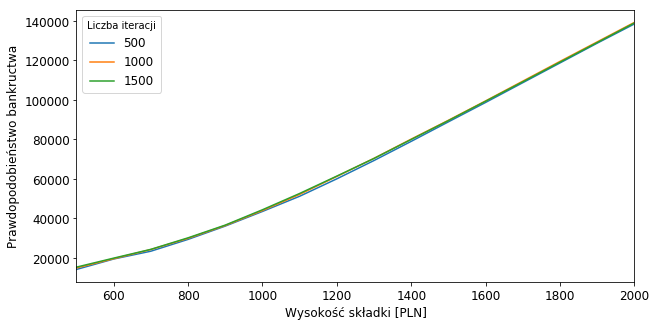

In [50]:
fig, ax = plt.subplots(figsize = (10,5))
df2.loc[(slice(None), 10000, slice(None)),:].reset_index().groupby('iteracje'). \
    plot(x = 'skladka', y = 'sr_wynik', legend = False, fontsize = 12, ax = ax)
ax.set_ylabel('Prawdopodobieństwo bankructwa', fontsize = 12)
ax.set_xlabel('Wysokość składki [PLN]', fontsize = 12)
ax.legend(labels = ['500', '1000', '1500'], title = 'Liczba iteracji', fontsize = 12)

In [ ]:
# Zapisuję do pliku, żeby nie musieć symulować wszystkiego od nowa
dane.to_hdf('dane.hdf', key = 'dane')
lambda_up.to_hdf('dane.hdf', key = 'lambda_up')
lambda_down.to_hdf('dane.hdf', key = 'lambda_down')
piecset.to_hdf('dane.hdf', key = 'piecset')
tys_piecset.to_hdf('dane.hdf', key = 'tys_piecset')